In [1]:
# Mount Google drive to acces files
from google.colab import drive
drive.mount('/content/drive')
import os
# Check if the packages are installed
    # Install torch geometric packages
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install dgl
!pip install umap-learn

    # Save installed packages
!pip freeze > /content/drive/MyDrive/torch_geometric_installed.txt
else:
    print("Torch geometric packages are already installed.")
    installed_packages_file = '/content/drive/MyDrive/torch_geometric_installed.txt'
    with open(installed_packages_file, 'r') as file:
      installed_packages = file.read().splitlines()

# Add the package paths to the current Python environment
    import sys
    for package in installed_packages:
      if package:
        !pip install $package

# Check if the packages are loaded
    !pip list






Mounted at /content/drive
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=504020 sha256=ce2364f6e998c7b47327fabd80b380896ee21b1948dd77308e171d0298bcd6f3
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1071448 sha256=d396e045977491fdac813392e388faaa5e9c9a9cedd976166952f1558cd6524a
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3

In [2]:
import torch_geometric
torch_geometric.__version__

'2.5.3'

In [3]:
!nvcc --version
!python -c "import torch; print(torch.version.cuda)"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
12.1


In [5]:
#import required packages
import copy
import dgl
import torch
import deepsnap
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from torch_scatter import scatter_mean

from torch import matmul
from sklearn.metrics import f1_score
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from torch_sparse import SparseTensor, matmul
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from deepsnap.hetero_graph import HeteroGraph
from collections import Counter
from umap import UMAP
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
#define args required for training as well as other parameters
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'hidden_size': 64,
    'epochs': 50,
    'weight_decay': 1e-6,
    'lr': 0.05,
    'eps': 1.0,
    'opt': 'adam',
    'opt_scheduler': 'none'
}

The following code creates a DGL graph as well as a directed DeepSnap graph. The Deepsnap graph is used in the rest of the code to calculate node-embeddings.

In [72]:

# Path to the XLSX files
gnn_data = '/content/drive/MyDrive/newxyz3_more_data.xlsx'
node_identities = '/content/drive/MyDrive/nodes_identities_10classes.xlsx'

# Load node features for 'system' nodes
system_features_df = pd.read_excel(node_identities)
system_features = torch.tensor(system_features_df[['possible number of binding transitions', '# of bound states', '# of unbound states', 'number of unbound states not for binding', '# of ubd-ubd transitions', 'number of unbound states for binding', 'singly bound states not for binding ', 'singly bound states for binding ', 'singly bd-singly bd transitions', 'doubly bound states not for binding ', 'doubly bound states for binding ', 'doubly bd- doubly bd transitions', 'triply bound states not for binding ' ]].values, dtype=torch.float32)

info_features_df = pd.read_excel(gnn_data)
info_features = torch.tensor(info_features_df[['attr1', 'attr2', 'attr3', 'attr4']].values, dtype=torch.float32)

# Create 'i_number' nodes
num_info_nodes = len(info_features)
info_number_graph = dgl.graph([], num_nodes=num_info_nodes)
info_number_graph.ndata['features'] = info_features.clone().detach()

# Create 'system' nodes
num_system_nodes = len(system_features)
system_graph = dgl.graph([], num_nodes=num_system_nodes)
system_graph.ndata['features'] = system_features.clone().detach()

# Create edges connecting 'i_number' nodes to 'system' nodes
dst_nodes = info_features_df['itr_number'].values.tolist()
src_nodes = info_features_df['Node_identity'].values.tolist()
#edges = [(src, dst) for src, dst in zip(src_nodes, dst_nodes)]
edges = [(src, dst) for src, dst in zip(src_nodes, dst_nodes)]  # Reverse the direction of edges

# Adjust node IDs to start from zero
node_id_mapping = {node_id: idx for idx, node_id in enumerate(set(src_nodes + dst_nodes))}
edges = [(node_id_mapping[src], node_id_mapping[dst]) for src, dst in edges]

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
print(edge_index.size())

# Construct a deepsnap tensor backend HeteroGraph
sensor_graph = HeteroGraph(
    node_feature={"system": system_features, "info": info_features},
    edge_index={('system', 'connects', 'info'): edge_index},
    directed=True
)

# Print DeepSNAP graph information
print(sensor_graph)
print(f"Heterogeneous graph: {sensor_graph.num_nodes()} nodes, {sensor_graph.num_edges()} edges")

# Node feature to device
for key in sensor_graph.node_feature:
    sensor_graph.node_feature[key] = sensor_graph.node_feature[key].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Edge_index to sparse tensor and to device
for key in sensor_graph.edge_index:
    edge_index = sensor_graph.edge_index[key]
    adj = SparseTensor(row=edge_index[1], col=edge_index[0], sparse_sizes=(sensor_graph.num_nodes('info'), sensor_graph.num_nodes('system')))
    adj = adj.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    #sensor_graph.edge_index[key] = adj
    sensor_graph.edge_index[key] = adj
print(sensor_graph.edge_index[('system', 'connects', 'info')])


torch.Size([2, 18000])
HeteroGraph(directed=[1], edge_index=[], edge_label_index=[], node_feature=[], node_label_index=[])
Heterogeneous graph: {'system': 36, 'info': 18000} nodes, {('system', 'connects', 'info'): 18000} edges
SparseTensor(row=tensor([  0,   0,   0,  ..., 499, 499, 499]),
             col=tensor([ 0,  1,  2,  ..., 33, 34, 35]),
             size=(18000, 36), nnz=18000, density=2.78%)


The following is the message passing layer that collects the information from the source nodes to the destination nodes through the directed edges and aggregates all the messages at the destination nodes.

In [73]:
class HeteroGNNConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels_src, in_channels_dst, out_channels):
        super(HeteroGNNConv, self).__init__(aggr='mean')  # "mean" aggregation
        self.in_channels_src = in_channels_src
        self.in_channels_dst = in_channels_dst
        self.out_channels = out_channels

        self.lin_src = nn.Linear(in_channels_src, out_channels)
        self.lin_dst = nn.Linear(in_channels_dst, out_channels)
        self.lin_update = nn.Linear(out_channels * 2, out_channels)  # Concatenation of aggr_out and node_feature_dst

    def forward(self, node_feature_src, node_feature_dst, edge_index, size=None):
        return self.propagate(edge_index=edge_index, size=size, node_feature_dst=node_feature_dst, node_feature_src=node_feature_src)

    def message_and_aggregate(self, edge_index, node_feature_src):
        out = matmul(edge_index, node_feature_src, reduce="mean")
        return out

    def update(self, aggr_out, node_feature_dst):
        aggr_out = self.lin_src(aggr_out)
        node_feature_dst = self.lin_dst(node_feature_dst)
        aggr_out = torch.cat([aggr_out, node_feature_dst], dim=-1)
        aggr_out = self.lin_update(aggr_out)
        return aggr_out


The following wrapper layer is designed to aggregate messages over a particular message type for graph that may contain multiple message types. In the current code there is just one message type.

In [74]:
class HeteroGNNWrapperConv(deepsnap.hetero_gnn.HeteroConv):
    def __init__(self, convs, args, aggr="mean"):
        super(HeteroGNNWrapperConv, self).__init__(convs, None)
        self.aggr = aggr
        self.mapping = {}
        self.alpha = None

    def reset_parameters(self):
        super(HeteroGNNWrapperConv, self).reset_parameters()

    def forward(self, node_features_src, node_features_dst, edge_indices):
        message_type_emb = {}
        message_key = ('system', 'connects', 'info')
        message_type_emb[message_key] = (
                self.convs[message_key](
                    node_features_src,
                    node_features_dst,
                    edge_indices,
                )
            )
        node_emb = {dst: [] for _, _, dst in message_type_emb.keys()}
        mapping = {}
        for (src, edge_type, dst), item in message_type_emb.items():
            mapping[len(node_emb[dst])] = (src, edge_type, dst)
            node_emb[dst].append(item)
        self.mapping = mapping
        for node_type, embs in node_emb.items():
            if len(embs) == 1:
                node_emb[node_type] = embs[0]
            else:
                node_emb[node_type] = self.aggregate(embs)
        return node_emb


    def aggregate(self, xs):
        if self.aggr == "mean":
            x = torch.stack(xs, dim=-1)
            return x.mean(dim=-1)


In [76]:
def generate_convs(hetero_graph, conv, hidden_size, first_layer=False):
    # print("generating convs")
    convs = {}
    message_type = hetero_graph.message_types
    if first_layer is True:
            src_type = message_type[0][0]
            print("src_type", src_type)
            dst_type = message_type[0][2]
            src_size = hetero_graph.num_node_features(src_type)
            dst_size = hetero_graph.num_node_features(dst_type)
            convs[message_type[0]] = conv(src_size, dst_size, hidden_size)
            # print(convs)
    else:
            convs[message_type[0]] = conv(hidden_size, hidden_size, hidden_size, hidden_size)
            # print(convs)
    return convs

In [81]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, hetero_graph, args, aggr="mean"):
        super(HeteroGNN, self).__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.aggr = aggr
        self.hidden_size = args['hidden_size']
        self.temperature = args.get('temperature', 0.5)

        self.bns1 = nn.ModuleDict()
        self.relus1 = nn.ModuleDict()
        self.post_mps = nn.ModuleDict()

        convs1 = generate_convs(hetero_graph, HeteroGNNConv, self.hidden_size, first_layer=True)
        self.convs1 = HeteroGNNWrapperConv(convs1, args, aggr=self.aggr)

        node_type = hetero_graph.node_types[1]
        self.bns1[node_type] = torch.nn.BatchNorm1d(self.hidden_size, eps=args['eps'])
        self.post_mps[node_type] = nn.Linear(self.hidden_size, 10)
        self.relus1[node_type] = nn.LeakyReLU()

    def forward(self, node_features_src, node_features_dst, edge_indices):
        node_emb = {dst: torch.empty(0, device=node_features_dst.device) for dst in range(node_features_dst.size(0))}
        for src in range(node_features_src.size(0)):
            for dst in range(node_features_dst.size(0)):
                combined_emb = torch.cat([node_features_src[src], node_features_dst[dst]], dim=0)
                node_emb[dst] = torch.cat([node_emb[dst], combined_emb.unsqueeze(0)], dim=0)
        for dst, embs in node_emb.items():
            if embs.size(0) == 1:
                node_emb[dst] = embs.squeeze(0)
        #print(node_emb)
        return node_emb

    def get_node_embeddings(self, node_features, edge_index):
        x_itr_number = node_features['info'].to(self.device)
        x_system = node_features['system'].to(self.device)
        edge_index = edge_index.to(self.device)
        x = self.convs1(x_system, x_itr_number, edge_index)
        # print(x)
        # print(x.size())
        return x['info']

    def unsupervised_loss(self, node_features, edge_indices):
        node_embeddings = self.get_node_embeddings(node_features, edge_indices)
        umap = UMAP(n_components=3, random_state=0)
        node_embeddings_umap = umap.fit_transform(node_embeddings.detach().cpu().numpy())
        kmeans = KMeans(n_clusters=10, random_state=0, n_init=10).fit(node_embeddings_umap)
        cluster_assignments = kmeans.labels_
        cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(self.device)
        node_embeddings_umap_tensor = torch.tensor(node_embeddings_umap, dtype=torch.float32).to(self.device).requires_grad_(True)
        loss = F.mse_loss(node_embeddings_umap_tensor, cluster_centers[cluster_assignments])
        return loss


In [79]:
def train(model, optimizer, hetero_graph):
    model.train()
    optimizer.zero_grad()
    preds = model(hetero_graph.node_feature['system'], hetero_graph.node_feature['info'], hetero_graph.edge_index[('system','connects','info')])

    # Assuming your model now uses K-means clustering for unsupervised loss
    unsupervised_loss = model.unsupervised_loss(hetero_graph.node_feature, hetero_graph.edge_index[('system','connects','info')])

    loss = unsupervised_loss
    loss.backward()
    optimizer.step()
    return loss.item()



In [59]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args['weight_decay']
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args['opt'] == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args['lr'], weight_decay=weight_decay)
    elif args['opt'] == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args['lr'], momentum=0.95, weight_decay=weight_decay)
    elif args['opt'] == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args['lr'], weight_decay=weight_decay)
    elif args['opt'] == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args['lr'], weight_decay=weight_decay)
    if args['opt_scheduler'] == 'none':
        return None, optimizer
    elif args['opt_scheduler'] == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args['opt_decay_step'], gamma=args['opt_decay_rate'])
    elif args['opt_scheduler'] == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args['opt_restart'])
    return scheduler, optimizer

In [82]:
# Set random seed for reproducibility
seed = 40
torch.manual_seed(seed)
np.random.seed(seed)

# Initialize the model and other components
model = HeteroGNN(sensor_graph, args, aggr="mean").to(args['device'])
scheduler, optimizer = build_optimizer(args, model.parameters())
best_loss = float('inf')
best_model = None

# Training loop
for epoch in range(args['epochs']):
    model.train()
    loss = train(model, optimizer, sensor_graph)  # No train_idx
    if loss < best_loss:
        best_loss = loss
        best_model = model.state_dict()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}: loss {round(loss, 5)}")

# Load the best model
model.load_state_dict(best_model)
model.eval()

# Obtain node embeddings from the best model
node_embeddings = model.get_node_embeddings(sensor_graph.node_feature, sensor_graph.edge_index[('info', 'connects', 'system')])

# Apply UMAP to reduce dimensionality to 3D for visualization
umap = UMAP(n_components=3, random_state=seed)
node_embeddings_umap = umap.fit_transform(node_embeddings.detach().cpu().numpy())

# Print the predictions of the best model
print("Predictions of the best model:")
print(kmeans_labels)

# Visualize the node embeddings using UMAP and K-means clustering
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(node_embeddings_umap[:, 0], node_embeddings_umap[:, 1], node_embeddings_umap[:, 2])
plt.title('3D UMAP Visualization of Node Embeddings')
plt.show()


src_type system
src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Epoch 10: loss 3.28806
src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Epoch 20: loss 3.28806
src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Epoch 30: loss 3.28806
src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Epoch 40: loss 3.28806
src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Epoch 50: loss 3.28806


KeyError: ('info', 'connects', 'system')

src_size must be 36 by 13: torch.Size([36, 13])
out_size after message and aggregate: torch.Size([18000, 13])
dst_size: torch.Size([18000, 4])
out_size after linear layer: torch.Size([18000, 64])
dst_size after linear layer: torch.Size([18000, 64])


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Predictions of the best model:
[6 6 6 ... 3 5 7]


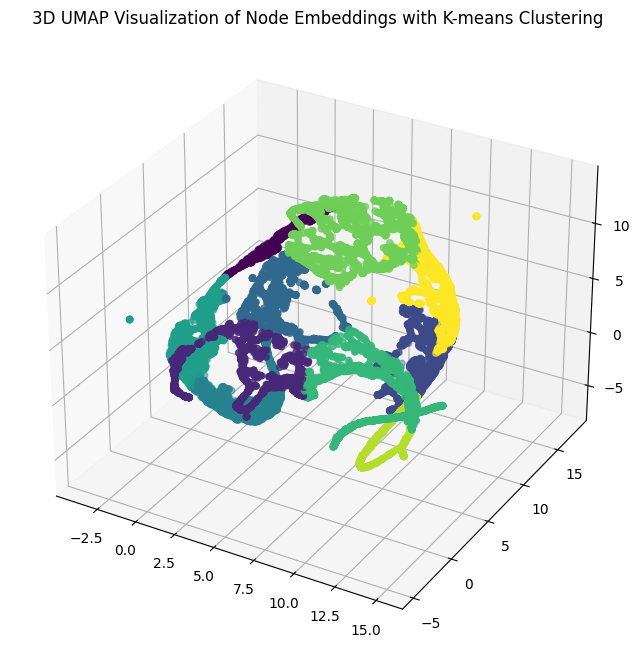

In [83]:
model.load_state_dict(best_model)
model.eval()

# Obtain node embeddings from the best model
node_embeddings = model.get_node_embeddings(sensor_graph.node_feature, sensor_graph.edge_index[('system', 'connects', 'info')])

# Apply UMAP to reduce dimensionality to 3D for visualization
umap = UMAP(n_components=3, random_state=seed)
node_embeddings_umap = umap.fit_transform(node_embeddings.detach().cpu().numpy())

# Perform K-means clustering
kmeans = KMeans(n_clusters=10, random_state=0, n_init=10)
kmeans_labels = kmeans.fit_predict(node_embeddings_umap)

# Print the predictions of the best model
print("Predictions of the best model:")
print(kmeans_labels)

# Visualize the node embeddings using UMAP and K-means clustering
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(node_embeddings_umap[:, 0], node_embeddings_umap[:, 1], node_embeddings_umap[:, 2], c=kmeans_labels, cmap='viridis')
plt.title('3D UMAP Visualization of Node Embeddings with K-means Clustering')
plt.show()

In [84]:
import os
import pandas as pd
import torch
from sklearn.cluster import KMeans
from umap import UMAP
import matplotlib.pyplot as plt
from torch_sparse import SparseTensor
from deepsnap.hetero_graph import HeteroGraph

# Assuming the rest of your data loading and preprocessing code is here

# Save the best model
best_model_path = 'best_model.pth'
torch.save(model.state_dict(), best_model_path)

# Load the best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Obtain node embeddings from the best model
node_embeddings = model.get_node_embeddings(sensor_graph.node_feature, sensor_graph.edge_index[('system', 'connects', 'info')])

# Apply UMAP to reduce dimensionality to 3D for visualization
umap = UMAP(n_components=3, random_state=0)
node_embeddings_umap = umap.fit_transform(node_embeddings.detach().cpu().numpy())

# Perform K-means clustering
kmeans = KMeans(n_clusters=10, random_state=0, n_init=10)
kmeans_labels = kmeans.fit_predict(node_embeddings_umap)

# Extract source and destination nodes from edge_index tensor
edge_index = sensor_graph.edge_index[('system', 'connects', 'info')].to_dense()
src_nodes = edge_index[0].tolist()
dst_nodes = edge_index[1].tolist()

# Create a DataFrame to store the information
df = pd.DataFrame({
    'node_embedding': [emb.tolist() for emb in node_embeddings.detach().cpu().numpy()],
    'node_embedding_umap': [emb.tolist() for emb in node_embeddings_umap],
    'predicted_class': kmeans_labels,
    'src_node': src_nodes,
    'dst_node': dst_nodes
})

# Save the DataFrame to a CSV file
output_csv = 'node_embeddings.csv'
df.to_csv(output_csv, index=False)

# Print the predictions of the best model
print("Predictions of the best model:")
print(kmeans_labels)

# Visualize the node embeddings using UMAP and K-means clustering
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(node_embeddings_umap[:, 0], node_embeddings_umap[:, 1], node_embeddings_umap[:, 2], c=kmeans_labels, cmap='viridis')
plt.title('3D UMAP Visualization of Node Embeddings with K-means Clustering')
plt.show()


ValueError: All arrays must be of the same length